# ECE 381K Applied Machine Learning Project (Group 10)

Use this playground to do EDA, feature/model selection, and run experiments! Make sure this notebook is self-contained.

List of cells for running project out-of-box:
 - [ ] pip freeze cell to get dependencies
 - [ ] CLEAR config management (try Hydra)
 - [ ] CLEAR hyperparameter tuning (try Optuna)
    - This can give some very nice plots for final report!
 - [ ] blah

## Acknowledgements

The authors acknowledge the following list of project notebooks and github repositories where they found motivation, or direct coding examples for this project.

- https://github.com/tubo213/kaggle-child-mind-institute-detect-sleep-states/tree/main


In [1]:
# from google.colab import drive

# drive.mount('/content/drive')

In [2]:
# ! pip install black
# ! pip install hydra-core --upgrade
# ! pip install vapeplot

In [3]:
# ! which pip

In [4]:
# ALL imports go here

import os
import jupyter_black
from IPython.display import Markdown
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

from sklearn.svm import SVC

import numpy as np
import polars as pl

# plotting utils and default globals
import matplotlib.pyplot as plt
import seaborn as sns
import gc

plt.style.use("ggplot")

plt.rcParams.update({'font.size': 18,
          'legend.fontsize': 'medium',
          'axes.titleweight': 'bold',
          'axes.labelweight': 'bold',
         'axes.labelsize': 18,
         'axes.titlesize': 20,
         'xtick.labelsize': 16,
         'ytick.labelsize': 16})

# set this to true to save figures locally / download them from the colab notebook
# by default set it to false
SAVE_FIGURES = False

In [5]:
ROOT_DIR = "/home/ss26/Projects/detecting-sleep-states/"
DATA_DIR = ROOT_DIR + "/data/"
PLOTS_DIR = ROOT_DIR + "/plots/"

CHUNK_SIZE = 1_000_000


In [6]:
train_series = pl.read_parquet(DATA_DIR + "train_series.parquet", n_rows=CHUNK_SIZE)
train_events = pl.read_csv(DATA_DIR + "train_events.csv")

In [7]:
train_series.head()

series_id,step,timestamp,anglez,enmo
str,u32,str,f32,f32
"""038441c925bb""",0,"""2018-08-14T15:…",2.6367,0.0217
"""038441c925bb""",1,"""2018-08-14T15:…",2.6368,0.0215
"""038441c925bb""",2,"""2018-08-14T15:…",2.637,0.0216
"""038441c925bb""",3,"""2018-08-14T15:…",2.6368,0.0213
"""038441c925bb""",4,"""2018-08-14T15:…",2.6368,0.0215


In [8]:
train_events.head()

series_id,night,event,step,timestamp
str,i64,str,i64,str
"""038441c925bb""",1,"""onset""",4992,"""2018-08-14T22:…"
"""038441c925bb""",1,"""wakeup""",10932,"""2018-08-15T06:…"
"""038441c925bb""",2,"""onset""",20244,"""2018-08-15T19:…"
"""038441c925bb""",2,"""wakeup""",27492,"""2018-08-16T05:…"
"""038441c925bb""",3,"""onset""",39996,"""2018-08-16T23:…"


`train_events.csv` provides the actual **y** variable, _onset_ or _wakeup_. Make a concatenated dataset to connect `train_series.parquet` which has accelerometer data with `train_events.csv`

In [9]:
def get_train_series(series):
    train_series = pl.read_parquet(DATA_DIR + "train_series.parquet", n_rows=CHUNK_SIZE)
    train_series = train_series.filter(pl.col('series_id') == series)
    train_events = pl.read_csv(DATA_DIR + "train_events.csv")
    train_events = train_events.filter(pl.col('series_id') == series)

    # cleaning etc.
    train_events = train_events.drop_nulls()
    train_events = train_events.with_columns(pl.col("step").cast(pl.Int64))
    train_series = train_series.with_columns(pl.col("step").cast(pl.Int64))

    # print(train_series)

    train_events = train_events.with_columns(pl.col('event').map_dict(remapping={'onset': 0, 'wakeup': 1})).rename({'event': 'awake'})
    # print(train_events)
    

    train = train_series.join(train_events.select(['step','awake']), on='step', how='left')
    
    
    train = train.with_columns(pl.col("awake").fill_null(strategy='backward'))
    train = train.with_columns(pl.col("awake").fill_null(1))
    # # final section:
    # # train_events.groupby('series_id').tail(1)["event"].unique()
    # # Result: the last event is always a "wakeup"
    train = train.with_columns(pl.col("awake").cast(pl.Int64))
    
    return(train)

In [10]:
series_to_plot = ['038441c925bb', '292a75c0b94e']

### anglez for series 038441c925bb


/home/ss26/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


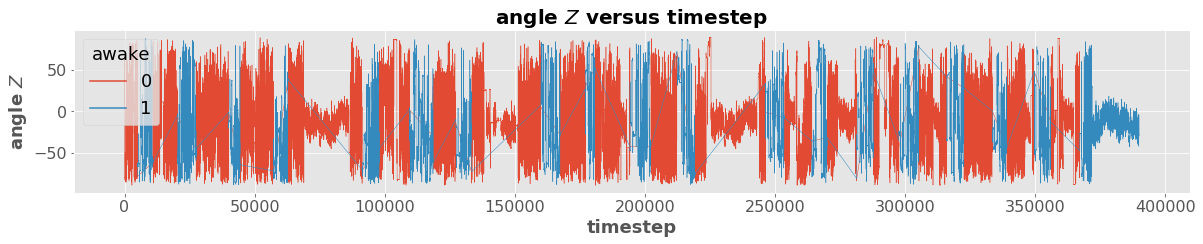

### enmo for series 038441c925bb


/home/ss26/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


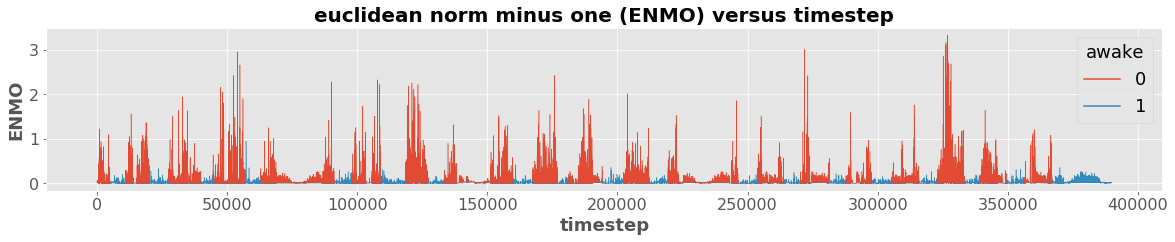

### anglez for series 292a75c0b94e


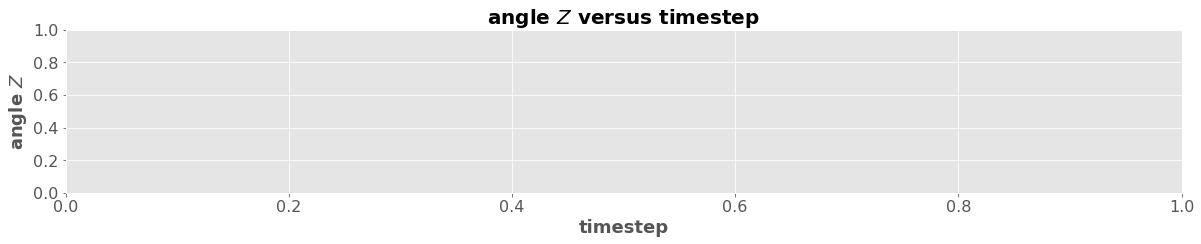

### enmo for series 292a75c0b94e


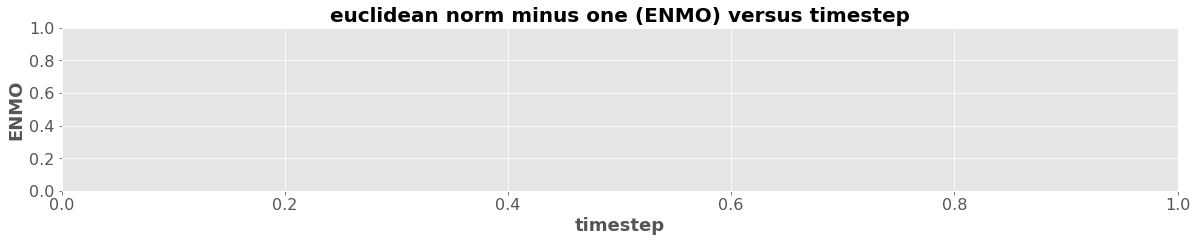

In [11]:
for series in series_to_plot:
    train = get_train_series(series)
    print('### anglez for series ' + series)
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=train, x="step", y="anglez",hue="awake", linewidth = 0.5)
    plt.xlabel("timestep")
    plt.ylabel("angle $Z$")
    plt.title("angle $Z$ versus timestep")

    if SAVE_FIGURES:
        fig.savefig(PLOTS_DIR + f'series_{series}_anglez_vs_timestep.png', bbox_inches='tight', dpi=200)
    else:
        plt.show()

    print('### enmo for series ' + series)
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=train, x="step", y="enmo",hue="awake", linewidth = 0.5)
    plt.xlabel("timestep")
    plt.ylabel("ENMO")
    plt.title("euclidean norm minus one (ENMO) versus timestep")

    if SAVE_FIGURES:
        fig.savefig(PLOTS_DIR + f'series_{series}_enmo_vs_timestep.png', bbox_inches='tight', dpi=200)
    else:
        plt.show()
        
    # del train
    # plt.gca()
    # gc.collect()

## Data Preprocessing

In [12]:
# Importing data 

# Column transformations

dt_transforms = [
    pl.col('timestamp').str.to_datetime(), 
    (pl.col('timestamp').str.to_datetime().dt.year()-2000).cast(pl.UInt8).alias('year'), 
    pl.col('timestamp').str.to_datetime().dt.month().cast(pl.UInt8).alias('month'),
    pl.col('timestamp').str.to_datetime().dt.day().cast(pl.UInt8).alias('day'), 
    pl.col('timestamp').str.to_datetime().dt.hour().cast(pl.UInt8).alias('hour')
]

data_transforms = [
    pl.col('anglez').cast(pl.Int16), # Casting anglez to 16 bit integer
    (pl.col('enmo')*1000).cast(pl.UInt16), # Convert enmo to 16 bit uint
]

train_series = pl.scan_parquet(DATA_DIR + 'train_series.parquet', n_rows=CHUNK_SIZE).with_columns(
    dt_transforms + data_transforms
    )

train_events = pl.read_csv(DATA_DIR + 'train_events.csv').with_columns(
    dt_transforms
    ).drop_nulls()

test_series = pl.scan_parquet(DATA_DIR + 'test_series.parquet').with_columns(
    dt_transforms + data_transforms
    )

# Removing null events and nights with mismatched counts from series_events
mismatches = train_events.drop_nulls().group_by(['series_id', 'night']).agg([
    ((pl.col('event') == 'onset').sum() == (pl.col('event') == 'wakeup').sum()).alias('balanced')
    ]).sort(by=['series_id', 'night']).filter(~pl.col('balanced'))

for mm in mismatches.to_numpy(): 
    train_events = train_events.filter(~((pl.col('series_id') == mm[0]) & (pl.col('night') == mm[1])))

# Getting series ids as a list for convenience
series_ids = train_events['series_id'].unique(maintain_order=True).to_list()

# Updating train_series to only keep these series ids
train_series = train_series.filter(pl.col('series_id').is_in(series_ids))

In [13]:
features, feature_cols = [pl.col('hour')], ['hour']

for mins in [5, 30, 60*2, 60*8] :
    
    for var in ['enmo', 'anglez'] :
        
        features += [
            pl.col(var).rolling_mean(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_mean'),
            pl.col(var).rolling_max(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_max'),
            pl.col(var).rolling_std(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_std')
        ]

        feature_cols += [ 
            f'{var}_{mins}m_mean', f'{var}_{mins}m_max', f'{var}_{mins}m_std'
        ]

        # Getting first variations
        features += [
            (pl.col(var).diff().abs().rolling_mean(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_mean'),
            (pl.col(var).diff().abs().rolling_max(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_max'),
            (pl.col(var).diff().abs().rolling_std(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_std')
        ]

        feature_cols += [ 
            f'{var}_1v_{mins}m_mean', f'{var}_1v_{mins}m_max', f'{var}_1v_{mins}m_std'
        ]

id_cols = ['series_id', 'step', 'timestamp']

train_series = train_series.with_columns(
    features
).select(id_cols + feature_cols)

test_series = test_series.with_columns(
    features
).select(id_cols + feature_cols)

In [19]:
pl.__version__

'0.19.13'

In [14]:
def make_train_dataset(train_data, train_events, drop_nulls=False) :
    
    series_ids = train_data['series_id'].unique(maintain_order=True).to_list()
    X, y = pl.DataFrame(), pl.DataFrame()
    for idx in tqdm(series_ids) : 
        
        # Normalizing sample features
        sample = train_data.filter(pl.col('series_id')==idx).with_columns(
            [(pl.col(col) / pl.col(col).std()).cast(pl.Float32) for col in feature_cols if col != 'hour']
        )
        
        events = train_events.filter(pl.col('series_id')==idx)
        
        if drop_nulls : 
            # Removing datapoints on dates where no data was recorded
            sample = sample.filter(
                pl.col('timestamp').dt.date().is_in(events['timestamp'].dt.date())
            )
        
        X = X.vstack(sample[id_cols + feature_cols])

        onsets = events.filter((pl.col('event') == 'onset') & (pl.col('step') != None))['step'].to_list()
        wakeups = events.filter((pl.col('event') == 'wakeup') & (pl.col('step') != None))['step'].to_list()

        # NOTE: This will break if there are event series without any recorded onsets or wakeups
        y = y.vstack(sample.with_columns(
            sum([(onset <= pl.col('step')) & (pl.col('step') <= wakeup) for onset, wakeup in zip(onsets, wakeups)]).cast(pl.Boolean).alias('asleep')
            ).select('asleep')
            )
    
    y = y.to_numpy().ravel()
    
    return X, y

In [15]:
def get_events(series, classifier) :
    '''
    Takes a time series and a classifier and returns a formatted submission dataframe.
    '''
    
    series_ids = series['series_id'].unique(maintain_order=True).to_list()
    events = pl.DataFrame(schema={'series_id':str, 'step':int, 'event':str, 'score':float})

    for idx in tqdm(series_ids) : 

        # Collecting sample and normalizing features
        scale_cols = [col for col in feature_cols if (col != 'hour') & (series[col].std() !=0)]
        X = series.filter(pl.col('series_id') == idx).select(id_cols + feature_cols).with_columns(
            [(pl.col(col) / series[col].std()).cast(pl.Float32) for col in scale_cols]
        )

        # Applying classifier to get predictions and scores
        preds, probs = classifier.predict(X[feature_cols]), classifier.predict_proba(X[feature_cols])[:, 1]

        #NOTE: Considered using rolling max to get sleep periods excluding <30 min interruptions, but ended up decreasing performance
        X = X.with_columns(
            pl.lit(preds).cast(pl.Int8).alias('prediction'), 
            pl.lit(probs).alias('probability')
                        )
        
        # Getting predicted onset and wakeup time steps
        pred_onsets = X.filter(X['prediction'].diff() > 0)['step'].to_list()
        pred_wakeups = X.filter(X['prediction'].diff() < 0)['step'].to_list()
        
        if len(pred_onsets) > 0 : 
            
            # Ensuring all predicted sleep periods begin and end
            if min(pred_wakeups) < min(pred_onsets) : 
                pred_wakeups = pred_wakeups[1:]

            if max(pred_onsets) > max(pred_wakeups) :
                pred_onsets = pred_onsets[:-1]

            # Keeping sleep periods longer than 30 minutes
            sleep_periods = [(onset, wakeup) for onset, wakeup in zip(pred_onsets, pred_wakeups) if wakeup - onset >= 12 * 30]

            for onset, wakeup in sleep_periods :
                # Scoring using mean probability over period
                score = X.filter((pl.col('step') >= onset) & (pl.col('step') <= wakeup))['probability'].mean()

                # Adding sleep event to dataframe
                events = events.vstack(pl.DataFrame().with_columns(
                    pl.Series([idx, idx]).alias('series_id'), 
                    pl.Series([onset, wakeup]).alias('step'),
                    pl.Series(['onset', 'wakeup']).alias('event'),
                    pl.Series([score, score]).alias('score')
                ))

    # Adding row id column
    events = events.to_pandas().reset_index().rename(columns={'index':'row_id'})

    return events

## Training Models

In [18]:
'''
from sklearn.model_selection import train_test_split

train_ids, val_ids = train_test_split(series_ids, train_size=0.7, random_state=42)

# We will collect datapoints at 10 minute intervals for training for validating
train_data = train_series.filter(pl.col('series_id').is_in(train_ids)).take_every(12 * 10).collect()

val_data = train_series.filter(pl.col('series_id').is_in(val_ids)).collect()
val_solution = train_events.filter(pl.col('series_id').is_in(val_ids)).select(['series_id', 'event', 'step']).to_pandas()
'''

# Collecting datapoints at every 5 minutes
train_data = train_series.filter(pl.col('series_id').is_in(series_ids)).take_every(12 * 5).collect()

thread '<unnamed>' panicked at /home/runner/work/polars/polars/crates/polars-time/src/chunkedarray/rolling_window/dispatch.rs:204:9:
not implemented
thread '<unnamed>' panicked at /home/runner/work/polars/polars/crates/polars-time/src/chunkedarray/rolling_window/dispatch.rs:204:9:
not implemented
thread '<unnamed>' panicked at /home/runner/work/polars/polars/crates/polars-time/src/chunkedarray/rolling_window/dispatch.rs:204:9:
not implemented
thread '<unnamed>' panicked at /home/runner/work/polars/polars/crates/polars-time/src/chunkedarray/rolling_window/dispatch.rs:204:9:
not implemented
thread '<unnamed>thread '<unnamed>' panicked at /home/runner/work/polars/polars/crates/polars-time/src/chunkedarray/rolling_window/dispatch.rs:204:9:
not implemented
' panicked at /home/runner/work/polars/polars/crates/polars-time/src/chunkedarray/rolling_window/dispatch.rs:204:9:
not implemented
thread '<unnamed>' panicked at /home/runner/work/polars/polars/crates/polars-time/src/chunkedarray/rolling

PanicException: not implemented

In [22]:
X_train, y_train = pl.read_parquet(DATA_DIR + 'training_data/X_train.parquet'), np.load(DATA_DIR + 'training_data/y_train.npy')